Welcome to my first, and rather long post on data analysis. Recently retook Andrew Ng's [machine learning course](https://www.coursera.org/learn/machine-learning) on Coursera, which I highly recommend as an intro course, and [Harvard's CS109 Data Science](http://cs109.github.io/2015/) that's filled with practical python examples and tutorials, so I thought I'd apply what I've learned with some real-life data sets.

Kaggle's [Titanic competition](https://www.kaggle.com/c/titanic) is part of their "getting started" competition for budding data scientists. The forum is well populated with many sample solutions and pointers, so I'd thought I'd whipping up a classifier and see how I fare on the Titanic journey.

## Introduction and Conclusion (tl;dr)

Given the elaborative post, thought it'd be a good idea to post my thoughts at the very top for the less patient. 

The web version of this notebook might be a bit hard to digest, if you'd like to try running each of the python cell blocks and to play around with the data, click [here](https://github.com/Estinox/coding-practices/blob/master/kaggle/titanic/titanic_kaggle.ipynb) for a copy.

I'll skip the introduction to what Titanis is about, as for the competition, this notebook took me about 3 weekends to complete, given the limited number of training size, so throwing away training rows wasn't optimal. Like any data science project, I started by exploring every raw feature that was given, trying to connect the high level relationships with what I know about ship wrecks. Once I felt comfortable with the data set, a majority of my time was impute missing values by cleaning and engineering new features. Without referring to external resources, there's quite a bit of creativity that's needed to come up with differentiating factors.

The way I wanted to construct this post is to give a narrative of my analysis by starting with some introductory exploration then making incremental conclusions. Everything is written in python with Jupyter notebook, so it's easy to clone my repo and fiddle around with the data yourself, so let's get started!

## Table of Contents
* [Data Libraries](#Load-Data-Set-and-Libraries)
* [Data Exploration](#Data-Exploration)
  * [Sex](#Sex)
  * [Passenger Class](#Passenger-Class)
  * [Port of Embarkment](#Port-of-Embarkment)
  * [Age](#Age)
  * [Fare](#Fare)
  * [Cabin](#Cabin)
* [Feature Engineering](#Feature-Engineering)
  * [Title](#Extract-Title-from-Name)
  * [Family Size](#Family-Size)
  * [Lone Traveller](#Lone-Travellers)
  * [Family Name](#Family-Name)
* [Impute Missing Values](#Impute-Missing-Values)
  * [Label Encoding](#Label-Encoding)
  * [Embarked](#Embarked)
  * [Ticket](#Ticket)
  * [Impute Age](#Impute-Age)
  * [Impute Fare](#Impute-Fare)
  * [Mother](#Mother)
  * [Cabin Class](#Cabin-Class)
  * [Cabin Number](#Cabin-Number)
  * [Cabin N-Tile](#Cabin-N-Tile)
* [Model Fitting](#Model-Fitting)
  * [Base Line](#Base-Line)
  * [Null Checks](#Null-Checks)
  * [Fitting](#Fitting)
* [Conclusion](#Conclusion)

## Load Data Set and Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
from sklearn import neighbors

%matplotlib inline

Read in our data set into train and test, then combine the two data frames to form a union of features for future data imputation.

In [2]:
# Read into our datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test['Survived'] = np.NAN

union = pd.concat([train, test])

## Data Exploration

In this section, we'll explore some basic structure of our data and try to come up creative ways of reformatting our features to make it more machine readable.

But first, let's famarize ourselves with the formatting of our data set.

In [3]:
union.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


### Sex
Now that you have a rough understanding of what each feature entail. Let's first start by exploring how gender is related to the overall survival rate.

In [4]:
survived_filter = ~union.Survived.isnull()

survived_by_sex = union[survived_filter] [['Sex', 'Survived']].groupby('Sex').sum()

survived_by_sex['People'] = union[survived_filter].groupby('Sex').count().Survived

survived_by_sex['PctSurvived'] = survived_by_sex.Survived / survived_by_sex.People

survived_by_sex

,Survived,People,PctSurvived
Sex,,,
female,233.0,314,0.742038
male,109.0,577,0.188908


This makes sense, Titanic's evacuation procedure had a women and children first policy. So, vast majority of the women were led into a safety boat.

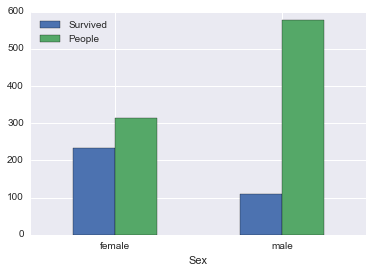

In [5]:
survived_by_sex[['Survived', 'People']].plot(kind='bar', rot=0)

### Passenger Class

What about survivial with respect to each passenger class (Pclass)? Do people with higher social class tend live through the catastrophe?

In [6]:
survived_by_pclass = union[survived_filter][['Pclass', 'Survived']].groupby('Pclass').sum()

survived_by_pclass['People'] = union[survived_filter].groupby('Pclass').count().Survived

survived_by_pclass['PctSurvived'] = survived_by_pclass.Survived / survived_by_pclass.People

survived_by_pclass

,Survived,People,PctSurvived
Pclass,,,
1,136.0,216,0.629630
2,87.0,184,0.472826
3,119.0,491,0.242363


So people in higher pclasses do have higher survivability. It's hard to say why without digging into the details, maybe it's the way they're dressed, the way they conduct themselves during emergencies, better connected, or a higher percentage of women (which we found from earlier exploration that females tend to be led into life boats easier). All these questions are things we want to keep in mind.

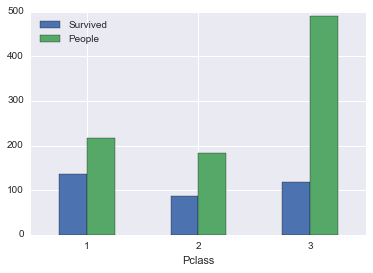

In [7]:
survived_by_pclass[['Survived', 'People']].plot(kind='bar', rot=0)

How about if we separated social class and gender, how does our survival rate look?

In [8]:
survived_by_pclass_sex = union[survived_filter].groupby(['Sex', 'Pclass']) \
    .apply(lambda x: x.Survived.sum() / len(x)) \
    .unstack()

survived_by_pclass_sex

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Looks between passenger classes, male in higher classes gets the biggest survivability boost. And let's graph this for some visuals.

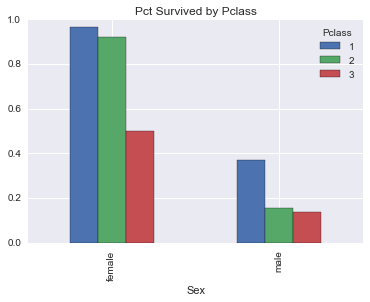

In [9]:
survived_by_pclass_sex.plot(kind='bar', title='Pct Survived by Pclass')

### Port of Embarkment

In [10]:
survived_by_embarked = union[survived_filter][['Embarked', 'Survived']].groupby('Embarked').sum()

survived_by_embarked['People'] = union[survived_filter][['Embarked', 'Survived']].groupby('Embarked').count()

survived_by_embarked['PctSurvived'] = survived_by_embarked.Survived/survived_by_embarked.People

survived_by_embarked

,Survived,People,PctSurvived
Embarked,,,
C,93.0,168,0.553571
Q,30.0,77,0.389610
S,217.0,644,0.336957


So embarking at port C gives a higher survivability rate, I wonder why.

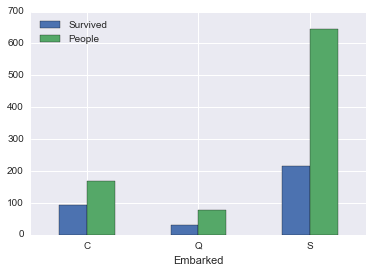

In [11]:
survived_by_embarked[['Survived', 'People']].plot(kind='bar', rot=0)

### Age

So was the Titanic filled with kids? or seniors?

I've grouped people into buckets of 5 years, starting with age 0.

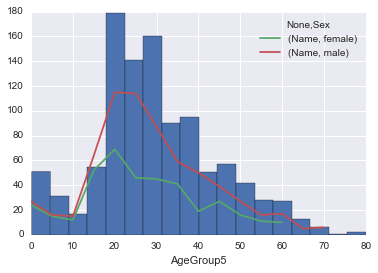

In [12]:
union.loc[~union.Age.isnull(), 'AgeGroup5'] = union.Age.dropna().apply(lambda x: int(x/5)*5)

ax = union.Age.hist(bins=len(union.AgeGroup5.unique()))
union[['Sex', 'AgeGroup5', 'Name']].groupby(['AgeGroup5', 'Sex']).count().unstack('Sex').plot(ax=ax)

We can get a bit more granular, let's break down the ages by passenger classes.

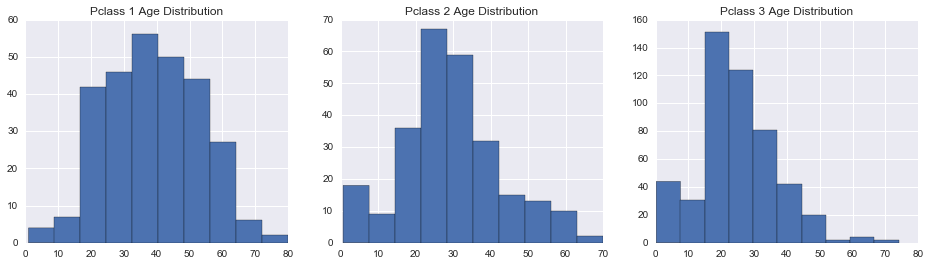

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i in range(3):
    union[union.Pclass == i+1]['Age'].hist(ax = axes[i])
    axes[i].set_title("Pclass {} Age Distribution".format(i+1))

So we think that kids, like females, were given priority during the evacuation. Let's check if this this true.

In [14]:
survived_by_agegroup5 = union[~union.Survived.isnull()][['AgeGroup5', 'Survived']].groupby('AgeGroup5').sum()

survived_by_agegroup5['People'] = union[~union.Survived.isnull()][['AgeGroup5', 'Survived']].groupby('AgeGroup5').count()

survived_by_agegroup5['PctSurvived'] = survived_by_agegroup5.Survived/survived_by_agegroup5.People

survived_by_agegroup5.head()

,Survived,People,PctSurvived
AgeGroup5,,,
0.0,27.0,40,0.675000
5.0,11.0,22,0.500000
10.0,7.0,16,0.437500
15.0,34.0,86,0.395349
20.0,39.0,114,0.342105


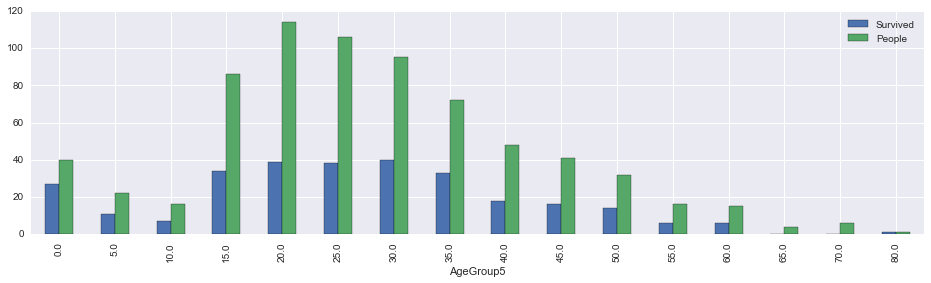

In [15]:
survived_by_agegroup5[['Survived', 'People']].plot(kind='bar', figsize=(16,4))

#### Running survival rate

Thought I'd try something different by plotting the cumulative survival rate from age 0, to see how it drops off as you get older.

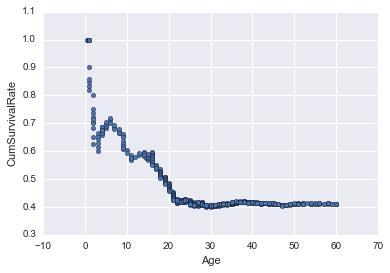

In [16]:
survived_by_age = union[~union.Survived.isnull()][train.Age <= 60][['Age', 'Survived']].sort_values('Age')

survived_by_age['CumSurvived'] = survived_by_age.Survived.cumsum()

survived_by_age['CumCount'] = [x+1 for x in range(len(survived_by_age))]

survived_by_age['CumSurvivalRate'] = survived_by_age.CumSurvived / survived_by_age.CumCount

survived_by_age.plot(kind='scatter', x='Age', y='CumSurvivalRate')

In [17]:
survived_by_age[(survived_by_age.Age >= 5) & (survived_by_age.Age <= 8)].head()

,Age,Survived,CumSurvived,CumCount,CumSurvivalRate
233,5.0,1.0,28.0,41,0.682927
58,5.0,1.0,29.0,42,0.690476
777,5.0,1.0,30.0,43,0.697674
448,5.0,1.0,31.0,44,0.704545
751,6.0,1.0,32.0,45,0.711111


### Fare

Fare by default is like a proxy for passenger class. The more expensive the fare, the wealthier you are.

Anyways, let's visual what the actual fare price distribution looks like.

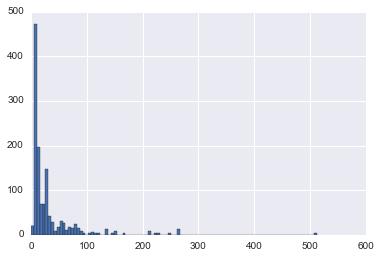

In [18]:
union.Fare.hist(bins=100)

In [19]:
union[['Pclass', 'Fare']].groupby('Pclass').describe().unstack()

Fare                                                                 
        count       mean        std  min      25%      50%       75%       max
Pclass                                                                        
1       323.0  87.508992  80.447178  0.0  30.6958  60.0000  107.6625  512.3292
2       277.0  21.179196  13.607122  0.0  13.0000  15.0458   26.0000   73.5000
3       708.0  13.302889  11.494358  0.0   7.7500   8.0500   15.2458   69.5500

We need to come back and revisit Fare, since there are fares prices at $0 or null.

In [20]:
fare_invalid_filter = (union.Fare.isnull()) | (union.Fare < 1)
len(union[fare_invalid_filter])

18

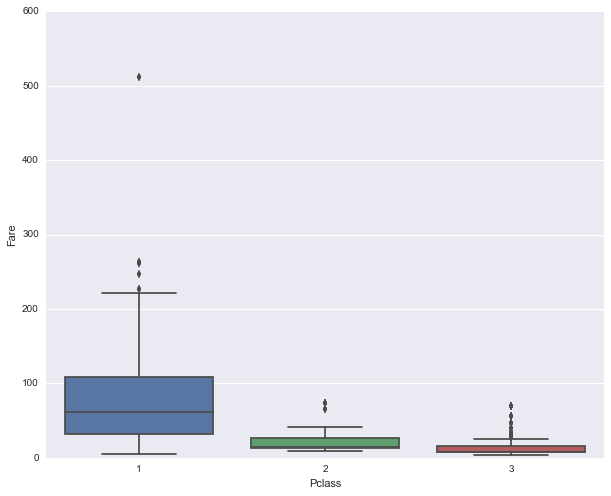

In [21]:
fig, ax = plt.subplots(figsize=(10,8))

sns.boxplot(data=union[~fare_invalid_filter], x='Pclass', y='Fare', ax=ax)

Let's see if there's a relationshp between fare price and those who has survived

In [22]:
union[['Pclass', 'Fare']][(~fare_invalid_filter) & (union.Survived == 1)].groupby('Pclass').describe().unstack()

Fare                                                                \
        count       mean        std      min       25%      50%         75%   
Pclass                                                                        
1       136.0  95.608029  85.286820  25.9292  50.98545  77.9583  111.481225   
2        87.0  22.055700  10.853502  10.5000  13.00000  21.0000   26.250000   
3       118.0  13.810946  10.663057   6.9750   7.77500   8.5896   15.887500   

                  
             max  
Pclass            
1       512.3292  
2        65.0000  
3        56.4958

In [23]:
union[['Pclass', 'Fare']][(~fare_invalid_filter) & (union.Survived == 0)].groupby('Pclass').describe().unstack()

Fare                                                                
        count       mean        std      min      25%    50%      75%     max
Pclass                                                                       
1        75.0  68.996275  60.224407   5.0000  29.7000  50.00  79.2000  263.00
2        91.0  20.692262  14.938248  10.5000  12.9375  13.00  26.0000   73.50
3       369.0  13.780497  12.104365   4.0125   7.7500   8.05  15.2458   69.55

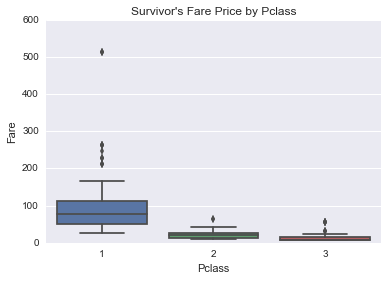

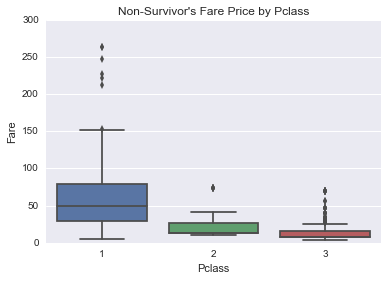

In [24]:
sns.boxplot(data=union[(~fare_invalid_filter) & (union.Survived == 1)], x='Pclass', y='Fare')
plt.title("Survivor's Fare Price by Pclass")

plt.figure()
sns.boxplot(data=union[(~fare_invalid_filter) & (union.Survived == 0)], x='Pclass', y='Fare')
plt.title("Non-Survivor's Fare Price by Pclass")

Percentage of people surivived by pclass

And not surpringly, people in better passenger classes had higher surivival rate

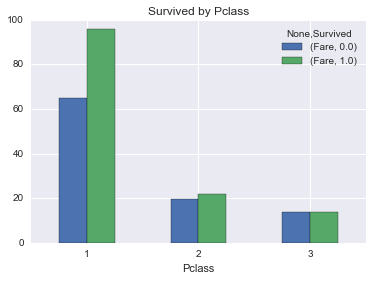

In [25]:
survived_by_fare_pclass = union[~union.Survived.isnull()][['Fare', 'Survived', 'Pclass']].groupby(['Pclass', 'Survived']).mean().unstack('Survived')
survived_by_fare_pclass.plot(kind='bar', rot=0)
plt.title('Survived by Pclass')

### Cabin

There's a lot of missing values in the cabin feature, but let's check it out anyways. We would think that the closer your cabin is to the life rafts, the better your chances are.

First, we need to strip out the cabin number in the cabin column.

In [26]:
# Define cabin class
union.loc[~union.Cabin.isnull(), 'CabinClass'] = union.Cabin.dropna().str[0]

In [27]:
cabinclass = union[~union.Survived.isnull()][['CabinClass', 'Survived']].groupby('CabinClass').sum()

cabinclass['People'] = union[~union.Survived.isnull()].groupby('CabinClass').count().Survived

cabinclass['PctSurvived'] = cabinclass.Survived / cabinclass.People

cabinclass['AvgFare'] = union[(~union.Survived.isnull()) & (~fare_invalid_filter)].groupby('CabinClass').mean().Fare

cabinclass['AvgAge'] = union[~union.Survived.isnull()].groupby('CabinClass').mean().Age

cabinclass['PctFemaleInCabin'] = union[~union.Survived.isnull()].groupby('CabinClass').apply(lambda x: len(x[x.Sex == 'female']) / len(x))

cabinclass

,Survived,People,PctSurvived,AvgFare,AvgAge,PctFemaleInCabin
CabinClass,,,,,,
A,7.0,15,0.466667,42.454164,44.833333,0.066667
B,35.0,47,0.744681,118.550464,34.955556,0.574468
C,35.0,59,0.593220,100.151341,36.086667,0.457627
D,25.0,33,0.757576,57.244576,39.032258,0.545455
E,24.0,32,0.750000,46.026694,38.116667,0.468750
F,8.0,13,0.615385,18.696792,19.954545,0.384615
G,2.0,4,0.500000,13.581250,14.750000,1.000000
T,0.0,1,0.000000,35.500000,45.000000,0.000000


Weird how there's a single person in cabin T ...

More visualizations by cabin class!

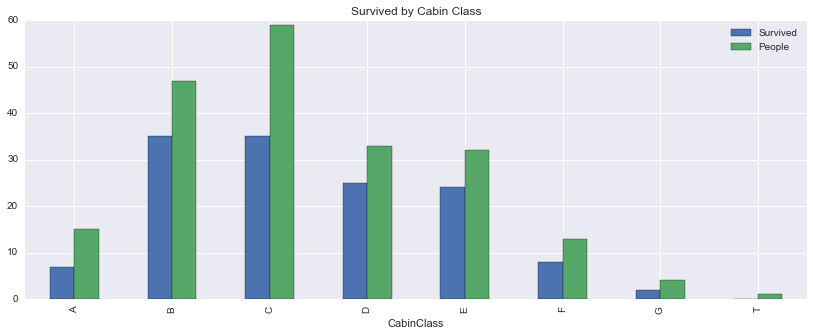

In [28]:
cabinclass[['Survived', 'People']].plot(kind='bar', figsize=(14,5), title='Survived by Cabin Class')

## Feature Engineering

Alright, the fun begins. Now we need to think of new features to add into our classifier, what can we deduce from the raw components we have already examined earlier?

One quick way of picking out the features with missing values is to look at the non-null count from the describe() function. Also, we can visually inspect the quantiles of each feature to see if it makes logically sense. For example, why does the Fare feature has a min price of 0?

In [29]:
union.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,AgeGroup5
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1046.00000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838,27.90631
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592,14.60369
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,20.00000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000,25.00000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,35.00000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000,80.00000


### Extracting Titles from Name

Name has a wealth of string information that we can take advantage of. Notice how each person has a prefix, maybe we can extract this out and use it to predict the age of the person if it's missing.

In [30]:
union['Title'] = union.Name.apply(lambda x: (x.split(',')[1]).split('.')[0][1:])
union[['Age','Title']].groupby('Title').describe().unstack()

Age                                                       
              count       mean        std    min    25%   50%    75%   max
Title                                                                     
Capt            1.0  70.000000        NaN  70.00  70.00  70.0  70.00  70.0
Col             4.0  54.000000   5.477226  47.00  51.50  54.5  57.00  60.0
Don             1.0  40.000000        NaN  40.00  40.00  40.0  40.00  40.0
Dona            1.0  39.000000        NaN  39.00  39.00  39.0  39.00  39.0
Dr              7.0  43.571429  11.731115  23.00  38.00  49.0  51.50  54.0
Jonkheer        1.0  38.000000        NaN  38.00  38.00  38.0  38.00  38.0
Lady            1.0  48.000000        NaN  48.00  48.00  48.0  48.00  48.0
Major           2.0  48.500000   4.949747  45.00  46.75  48.5  50.25  52.0
Master         53.0   5.482642   4.161554   0.33   2.00   4.0   9.00  14.5
Miss          210.0  21.774238  12.249077   0.17  15.00  22.0  30.00  63.0
Mlle            2.0  24.000000   0.000000  24.00  24.00  24.0  24.00  24.0
Mme             1.0  24.000000        NaN  24.00  24.00  24.0  24.00  24.0
Mr            581.0  32.252151  12.422089  11.00  23.00  29.0  39.00  80.0
Mrs           170.0  36.994118  12.901767  14.00  27.00  35.5  46.50  76.0
Ms              1.0  28.000000        NaN  28.00  28.00  28.0  28.00  28.0
Rev             8.0  41.250000  12.020815  27.00  29.50  41.5  51.75  57.0
Sir             1.0  49.000000        NaN  49.00  49.00  49.0  49.00  49.0
the Countess    1.0  33.000000        NaN  33.00  33.00  33.0  33.00  33.0

Are some titles tend to dominate in one gender?

In [31]:
union[['Sex','Title','Survived']].groupby(['Title','Sex']).sum().unstack('Sex')

Survived      
Sex            female  male
Title                      
Capt              NaN   0.0
Col               NaN   1.0
Don               NaN   0.0
Dona              NaN   NaN
Dr                1.0   2.0
Jonkheer          NaN   0.0
Lady              1.0   NaN
Major             NaN   1.0
Master            NaN  23.0
Miss            127.0   NaN
Mlle              2.0   NaN
Mme               1.0   NaN
Mr                NaN  81.0
Mrs              99.0   NaN
Ms                1.0   NaN
Rev               NaN   0.0
Sir               NaN   1.0
the Countess      1.0   NaN

Working with all these different kinds of titles can overfit our data, let's try classifying the less frequent titles into either Mr, Mrs, Miss, Master and Officer. The goal is to come up with the fewest number of unique titles that does not give us overlapping age ranges.

In [32]:
def title_mapping(x):
    #if x in set(['Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer']):
    if x.Title in set(['Don', 'Rev', 'Sir', 'Jonkheer']):
        return 'Mr'
    elif x.Title in set(['Lady', 'the Countess']):
        return 'Mrs'
    elif x.Title in set(['Mlle', 'Mme', 'Dona', 'Ms']):
        return "Miss"
    elif x.Title in set(['Major', 'Col', 'Capt']):
        return "Officer"
    elif x.Title == 'Dr' and x.Sex == 'female':
        return 'Mrs'
    elif x.Title == 'Dr' and x.Sex == 'male':
        return 'Mr'
    else:
        return x.Title

union.Title = union.apply(title_mapping, axis=1)
union.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Officer'], dtype=object)

Let see how well we have separated out the age groups by title.

In [33]:
union[['Age', 'Title']].groupby('Title').describe().unstack()

Age                                                     
         count       mean        std    min   25%   50%   75%   max
Title                                                              
Master    53.0   5.482642   4.161554   0.33   2.0   4.0   9.0  14.5
Miss     215.0  21.914372  12.171758   0.17  15.5  22.0  30.0  63.0
Mr       598.0  32.527592  12.476329  11.00  23.0  30.0  40.0  80.0
Mrs      173.0  37.104046  12.852049  14.00  27.0  36.0  47.0  76.0
Officer    7.0  54.714286   8.440266  45.00  49.5  53.0  58.0  70.0

### Family Size

In [34]:
union['FamilySize'] = union.Parch + union.SibSp + 1
union[['Parch', 'SibSp', 'FamilySize']][union.FamilySize > 3].head(3)

,Parch,SibSp,FamilySize
7,1,3,5
13,5,1,7
16,1,4,6


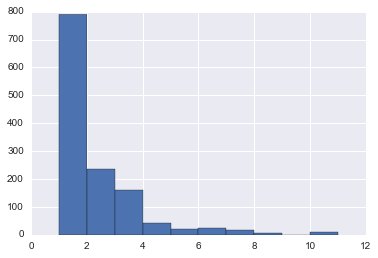

In [35]:
union.FamilySize.hist()

In [36]:
def family_size_bucket(x):
    if x <= 1:
        return "Single"
    elif x <= 3:
        return "Small"
    elif x <= 5: 
        return "Median"
    else:
        return "Large"
    
union['FamilySizeBucket'] = union.FamilySize.apply(family_size_bucket)

### Lone Travellers

Do people who travel by themselves tend to have lower chances of survival relative to passengers with families?

In [37]:
union['Alone'] = union.FamilySize.apply(lambda x: 1 if x == 1 else 0)

survived_by_alone = union[~union.Survived.isnull()][['Survived', 'Alone']].groupby('Alone').sum()
survived_by_alone['People'] = union[~union.Survived.isnull()][['Survived', 'Alone']].groupby('Alone').count()
survived_by_alone['PctSurvived'] = survived_by_alone.Survived / survived_by_alone.People
survived_by_alone

,Survived,People,PctSurvived
Alone,,,
0,179.0,354,0.505650
1,163.0,537,0.303538


### Family Name

Extract out the family names

In [38]:
union['FamilyName'] = union.Name.apply(lambda x: x.split(",")[0])

In [39]:
survived_by_family_name = union[['Survived', 'FamilyName']].groupby('FamilyName').sum()
survived_by_family_name['FamilySize'] = union[['FamilySize', 'FamilyName']].groupby('FamilyName').max()

survived_by_family_name.head()

,Survived,FamilySize
FamilyName,,
Abbing,0.0,1
Abbott,1.0,3
Abelseth,NaN,1
Abelson,1.0,2
Abrahamsson,NaN,1


Are families more likely to survive?

In [40]:
survived_by_family_size = survived_by_family_name.groupby('FamilySize').sum()
survived_by_family_size['FamilyCount'] = survived_by_family_name.groupby('FamilySize').count()
survived_by_family_size['PeopleInFamily'] = survived_by_family_size.FamilyCount * survived_by_family_size.index
survived_by_family_size['PctSurvived'] = survived_by_family_size.Survived / survived_by_family_size.PeopleInFamily

survived_by_family_size

,Survived,FamilyCount,PeopleInFamily,PctSurvived
FamilySize,,,,
1,153.0,475,475,0.322105
2,89.0,104,208,0.427885
3,65.0,59,177,0.367232
4,21.0,14,56,0.375000
5,4.0,6,30,0.133333
6,5.0,5,30,0.166667
7,5.0,2,14,0.357143
8,0.0,1,8,0.000000
11,0.0,1,11,0.000000


## Impute Missing Values

### Label Encoding

Categorical columns needs to be mapped to ints for some classifiers to work. We'll use the sklearn.preprocessing.LableEncoder() to help us with this.

In [41]:
encoder_list = ['Sex', 'Pclass', 'Title','FamilyName', 'FamilySizeBucket']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = encoder[i].fit_transform(union[e])


0 Sex
1 Pclass
2 Title
3 FamilyName
4 FamilySizeBucket


### Embarked

This is a bit of an overkill, but we have 1 passenger missing her port of emarkment. Simple analysis would've sufficed, but let's go the whole nine yards anyways for completeness' sake.

In [42]:
embarked_features = ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket',
       'CabinClass', 'Title', 'FamilySize', 'Alone', 'FamilyName']

In [43]:
embarked_breakdown = union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'Survived']].groupby(['Pclass', 'Embarked']).sum()

embarked_breakdown['Count'] = union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'Survived']].groupby(['Pclass', 'Embarked']).count()

embarked_breakdown['AvgFare'] = union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'Fare']].groupby(['Pclass', 'Embarked']).mean().Fare

embarked_breakdown['AvgAge'] = union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'Age']].groupby(['Pclass', 'Embarked']).mean().Age

embarked_breakdown

Survived  Count     AvgFare     AvgAge
Pclass Embarked                                        
1      C             59.0     85  106.845330  39.062500
       Q              1.0      2   90.000000  38.000000
       S             74.0    127   72.148094  39.121987

In [44]:
union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'CabinClass', 'Survived']].groupby(['Pclass', 'Embarked', 'CabinClass']).count()

Survived
Pclass Embarked CabinClass          
1      C        A                  7
                B                 22
                C                 21
                D                 11
                E                  5
       Q        C                  2
       S        A                  8
                B                 23
                C                 36
                D                 18
                E                 20
                T                  1

In [45]:
union.loc[union.Pclass == 1, ['Pclass', 'Embarked', 'Sex', 'Survived']].groupby(['Pclass', 'Embarked', 'Sex']).count()

Survived
Pclass Embarked Sex             
1      C        female        43
                male          42
       Q        female         1
                male           1
       S        female        48
                male          79

For imputation, let's train a k nearest neighbor classifer to figure out which port of embarkment you're from.

In [46]:
embarked_features = ['Parch', 'PclassEncoding', 'SexEncoding', 'SibSp',
                    'TitleEncoding', 'FamilySize', 'Alone', 'FamilyNameEncoding', 'FamilySizeBucketEncoding']

In [47]:
params = {'n_neighbors' : [5, 10, 15, 30, 50, 100, 200]}

clf_embarked = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsClassifier(), params, cv=5, n_jobs=4)
clf_embarked.fit(union[~union.Embarked.isnull()][embarked_features], union[~union.Embarked.isnull()].Embarked)

clf_embarked.predict(union[union.Embarked.isnull()][embarked_features])

array(['S', 'S'], dtype=object)

KNN tells us that our passenger with no port of embarkment probably boarded from "S", let's fill that in.

In [48]:
union.loc[union.Embarked.isnull(), 'Embarked'] = 'S'

Let's run our encoder code again on Embarked.

In [49]:
encoder_list = ['Embarked']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = encoder[i].fit_transform(union[e])


0 Embarked


### Ticket

There's a bit of judgemenet call in this one. The goal is to bucket the ticket strings into various classes. After going through all the labels, you slowly start to see some patterns.

In [50]:
def ticket_cleaning(x):
    ticket = x.split(' ')[0].replace('.', '').replace(r'/', '')
    if ticket.isdigit():
        return 'Integer_Group'
    elif 'TON' in ticket:
        return 'STON_Group'
    elif ticket[0] == 'A':
        return 'A_Group'
    elif ticket[0] == 'C':
        return 'C_Group'
    elif ticket[0] == 'F':
        return 'F_Group'
    elif ticket[0] == 'L':
        return 'L_Group'
    elif ticket[:2] == 'SC' or ticket == 'SOC':
        return 'SC_Group'
    elif ticket[:3] == 'SOP' or ticket == 'SP' or ticket == 'SWPP':
        return 'SP_Group'
    elif ticket[0] == 'P':
        return 'P_Group'
    elif ticket[0] == 'W':
        return 'W_Group'
    
    return ticket

union['TicketGroup'] = union['Ticket'].apply(ticket_cleaning)
union[['TicketGroup', 'Survived']].groupby('TicketGroup').count()

,Survived
TicketGroup,
A_Group,29
C_Group,46
F_Group,7
Integer_Group,661
L_Group,4
P_Group,65
SC_Group,23
SP_Group,7
STON_Group,36


In [51]:
encoder_list = ['TicketGroup']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = encoder[i].fit_transform(union[e])


0 TicketGroup


### Impute Age

Yay, if you actually read this far. Age is a very important factor in predicting survivability, so let's take in all the raw and engineered features and fill in the blanks for our passengers.

In [52]:
age_features = ['EmbarkedEncoding', 'SexEncoding', 'PclassEncoding',
                'Alone', 'SibSp', 'Parch', 'FamilySize', 'TitleEncoding', 'TicketGroupEncoding']

#clf_age = sklearn.linear_model.RidgeCV(alphas=[0.1, 0.5, 1, 3, 10])
#clf_age = sklearn.linear_model.RidgeCV(alphas=[0.1, 0.5, 1, 3, 10])

params = {'n_neighbors' : [5, 10, 15, 30, 50, 100, 200]}

clf_age = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsRegressor(), params, cv=5, n_jobs=4)
clf_age.fit(union[~union.Age.isnull()][age_features], union[~union.Age.isnull()].Age)
print(clf_age.best_params_)

{'n_neighbors': 15}


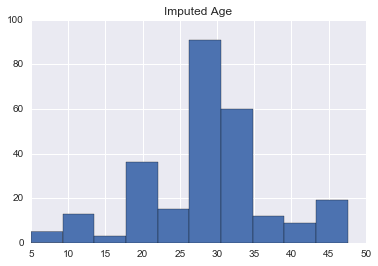

In [53]:
pd.Series(clf_age.predict(union[union.Age.isnull()][age_features])).hist()
plt.title('Imputed Age')

Now that we've trained our classifier, how does the new imputed age distribution look like compared to the old one?

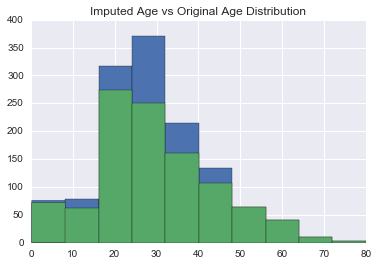

In [54]:
union['ImputedAge'] = union.Age
union.loc[(union.Age.isnull()), 'ImputedAge'] = clf_age.predict(union[(union.Age.isnull())][age_features])

union['ImputedAge'].hist()
union['Age'].hist()
plt.title('Imputed Age vs Original Age Distribution')

### Impute Fare

In [55]:
union[['Pclass', 'Fare']].groupby('Pclass').describe().unstack()

Fare                                                                 
        count       mean        std  min      25%      50%       75%       max
Pclass                                                                        
1       323.0  87.508992  80.447178  0.0  30.6958  60.0000  107.6625  512.3292
2       277.0  21.179196  13.607122  0.0  13.0000  15.0458   26.0000   73.5000
3       708.0  13.302889  11.494358  0.0   7.7500   8.0500   15.2458   69.5500

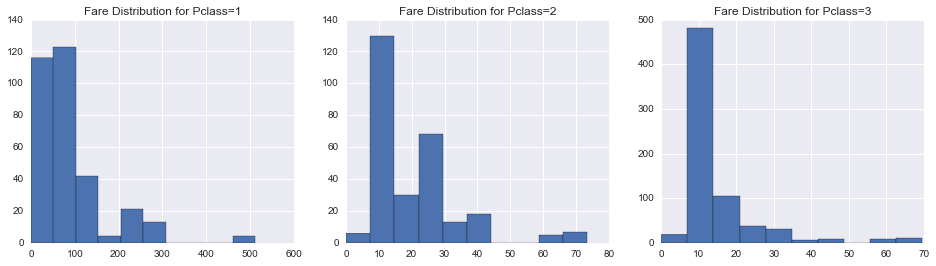

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

#union[['Pclass', 'Fare']]
for i, pclass in enumerate(np.sort(union.Pclass.unique())):
    union[union.Pclass == pclass].Fare.hist(ax=axes[i])
    axes[i].set_title('Fare Distribution for Pclass={}'.format(pclass))

In [57]:
fare_features_knn = ['EmbarkedEncoding', 'SexEncoding', 'PclassEncoding',
                'Alone', 'SibSp', 'Parch', 'FamilySize', 'TitleEncoding',
                 'ImputedAge', 'TicketGroupEncoding']

fare_features_ridge = ['EmbarkedEncoding', 'PclassEncoding',
                'Alone', 'SibSp', 'Parch', 'ImputedAge']

fare_features = fare_features_knn

params = {'n_neighbors' : [2, 4, 7, 10, 15, 30, 50, 100, 200]}
clf_fare = sklearn.grid_search.GridSearchCV(sklearn.neighbors.KNeighborsRegressor(), params, cv=5, n_jobs=4)

#clf_fare = sklearn.linear_model.RidgeCV(alphas=[0.1, 0.5, 1, 3, 10])

clf_fare.fit(union[~union.Fare.isnull()][fare_features], union[~union.Fare.isnull()].Fare)
#print(clf_fare.best_params_)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_neighbors': [2, 4, 7, 10, 15, 30, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [58]:
union.loc[((union.Fare.isnull()) | (union.Fare <= 0)), ['Pclass', 'Fare']].groupby('Pclass').count()

,Fare
Pclass,
1,7
2,6
3,4


In [59]:
union['ImputedFare'] = union.Fare

union.loc[union.Fare.isnull(), 'ImputedFare'] = clf_fare.predict(union[union.Fare.isnull()][fare_features])

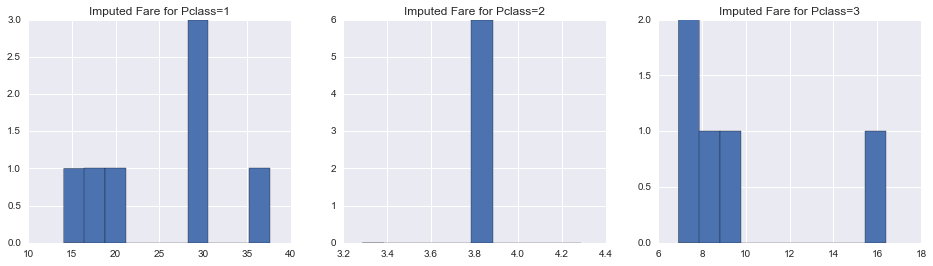

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, pclass in enumerate(np.sort(union.Pclass.unique())):
    null_fare_pclass_filter = ((union.Pclass == pclass) & ((union.Fare.isnull()) | (union.Fare <= 0)))
    pd.Series(clf_fare.predict(union[null_fare_pclass_filter][fare_features])).hist(ax=axes[i])
    axes[i].set_title('Imputed Fare for Pclass={}'.format(pclass))

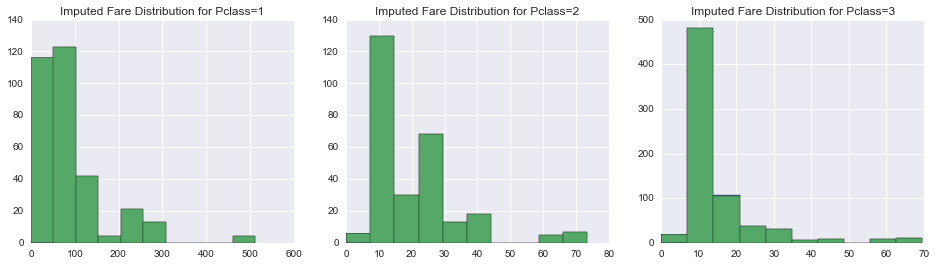

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, pclass in enumerate(np.sort(union.Pclass.unique())):
    union[union.Pclass == pclass].ImputedFare.hist(ax=axes[i])
    union[union.Pclass == pclass].Fare.hist(ax=axes[i])
    axes[i].set_title('Imputed Fare Distribution for Pclass={}'.format(pclass))

### Mother

"Mother and children first", so I think that's what they'd say as the Titanic is sinking. Let's try to identify the mothers using the passenger's gender, age, title, and whether if she has a child.

In [62]:
union['Mother'] = union.apply(lambda x: (x.Sex == 'female') & (x.ImputedAge >= 18) & (x.Parch > 0) & (x.Title == 'Mrs'), axis=1)

### Cabin Class

Yikes, there's quite a bit of missing cabin values to impute. Not sure how our classifier will do given the very limited number of training examples. Let's give it a shot anyways.

In [63]:
union.Cabin.isnull().sum()

1014

What are the different types of Cabin's given to us?

In [64]:
union.Cabin.unique()[:10]

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78'], dtype=object)

In [65]:
union.loc[~union.Cabin.isnull(), 'CabinClass'] = union.Cabin[~union.Cabin.isnull()].apply(lambda x: x[0])

In [66]:
encoder_list = ['CabinClass']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = union[e]
    union.loc[~union[e].isnull(), '{}Encoding'.format(e)] = encoder[i].fit_transform(union[~union[e].isnull()][e])


0 CabinClass


In [67]:
cabinclass_filter = ~union.CabinClass.isnull()

Probability of survival for each cabin class.

In [68]:
union[['CabinClass', 'Pclass', 'Survived']].groupby(['CabinClass', 'Pclass']).sum().unstack()

Survived          
Pclass            1    2    3
CabinClass                   
A               7.0  NaN  NaN
B              35.0  NaN  NaN
C              35.0  NaN  NaN
D              22.0  3.0  NaN
E              18.0  3.0  3.0
F               NaN  7.0  1.0
G               NaN  NaN  2.0
T               0.0  NaN  NaN

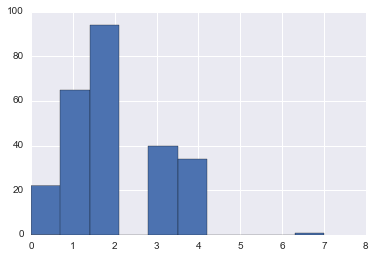

In [69]:
union.loc[(union.Pclass == 1) & (cabinclass_filter), 'CabinClassEncoding'].hist()

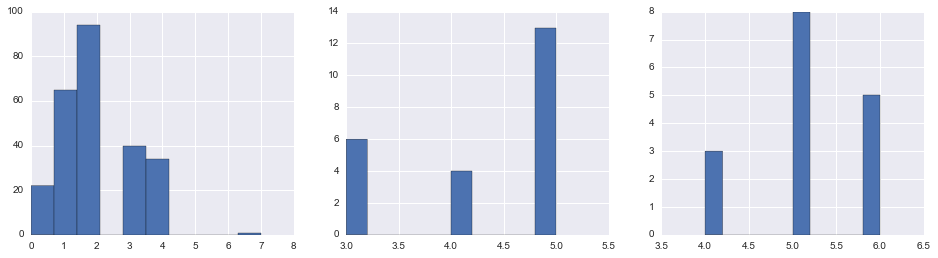

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

cabinclass_filter = ~union.CabinClass.isnull()
for i, pclass in enumerate(np.sort(union.Pclass.unique())):
    union.loc[(union.Pclass == pclass) & (cabinclass_filter), 'CabinClassEncoding'].hist(ax=axes[i])

In [71]:
cabinclass_features = ['ImputedAge', 'EmbarkedEncoding', 'ImputedFare', 'Parch', 'PclassEncoding',
                       'SexEncoding', 'SibSp', 'TicketGroupEncoding']

In [72]:
union['ImputedCabinClass'] = union.CabinClass

In [73]:

params_cabinclass = {'n_estimators': [10, 20, 30]}

clf_cabinclass = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), params_cabinclass)
clf_cabinclass.fit(union[cabinclass_filter][cabinclass_features], union[cabinclass_filter].CabinClass)

/Users/Estinox/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [74]:
union.loc[~cabinclass_filter, 'ImputedCabinClass'] = clf_cabinclass.predict(union[~cabinclass_filter][cabinclass_features])

In [75]:
encoder_list = ['ImputedCabinClass']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = union[e]
    union.loc[~union[e].isnull(), '{}Encoding'.format(e)] = encoder[i].fit_transform(union[~union[e].isnull()][e])


0 ImputedCabinClass


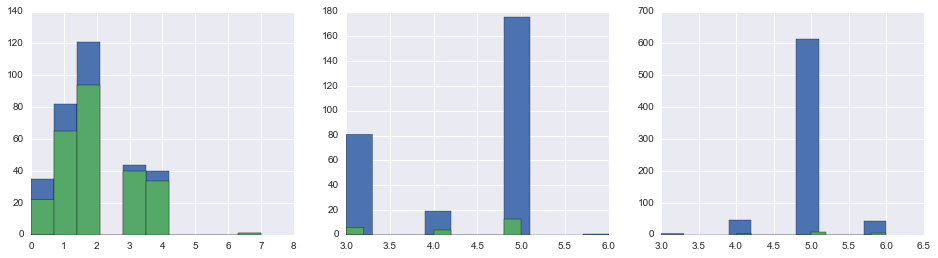

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))

for i, pclass in enumerate(np.sort(union.Pclass.unique())):
    union.loc[(union.Pclass == pclass), 'ImputedCabinClassEncoding'].hist(ax=axes[i])
    union.loc[(union.Pclass == pclass), 'CabinClassEncoding'].hist(ax=axes[i])

### Cabin Number

Trying to be a creative here. My hypothesis is that the cabin numbers are laid out either from the front to the back, so the number would indicate whether if the room is at the front, middle, or the back of the ship. 

In [77]:
def cabin_number_extract(x):
    if len(x) <= 1:
        return np.NAN
    
    for cabin in x.split(' '):
        if len(cabin) <= 1:
            continue
        else:
            return cabin[1:]
    return np.NAN

union.loc[~union.Cabin.isnull(), 'CabinNumber'] = union.Cabin[~union.Cabin.isnull()].apply(cabin_number_extract)

In [78]:
union[cabinclass_filter][['CabinNumber', 'Cabin']].head()

,CabinNumber,Cabin
1,85,C85
3,123,C123
6,46,E46
10,6,G6
11,103,C103


In [79]:
features_cabinnumber = ['ImputedAge', 'ImputedCabinClassEncoding', 'EmbarkedEncoding', 'ImputedFare', 'Parch',
                        'PclassEncoding', 'SibSp', 'SexEncoding', 'FamilySize', 'Alone', 'TitleEncoding',
                        'FamilyNameEncoding', 'TicketGroupEncoding', 'Mother']

In [80]:
encoder_list = ['CabinNumber']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = union[e]
    union.loc[~union[e].isnull(), '{}Encoding'.format(e)] = encoder[i].fit_transform(union[~union[e].isnull()][e])


0 CabinNumber


In [81]:
union['ImputedCabinNumber'] = union.CabinNumberEncoding

In [82]:
params_cabinnumber = {'n_estimators': [10, 20, 50, 100]}
clf_cabinnumber = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), params_cabinnumber)

#clf_cabinnumber = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

clf_cabinnumber.fit(union[~union.CabinNumber.isnull()][features_cabinnumber], union[~union.CabinNumber.isnull()].CabinNumberEncoding.astype(int))

/Users/Estinox/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [83]:
union.loc[union.CabinNumber.isnull(), 'ImputedCabinNumber'] = clf_cabinnumber.predict(union[union.CabinNumber.isnull()][features_cabinnumber])

In [84]:
encoder_list = ['ImputedCabinNumber']
encoder = []

for i, e in enumerate(encoder_list):
    print(i,e)
    encoder.append(sklearn.preprocessing.LabelEncoder())
    union['{}Encoding'.format(e)] = union[e]
    union.loc[~union[e].isnull(), '{}Encoding'.format(e)] = encoder[i].fit_transform(union[~union[e].isnull()][e])


0 ImputedCabinNumber


In [85]:
union[cabinclass_filter][['CabinNumber']].describe()

,CabinNumber
count,289
unique,104
top,6
freq,9


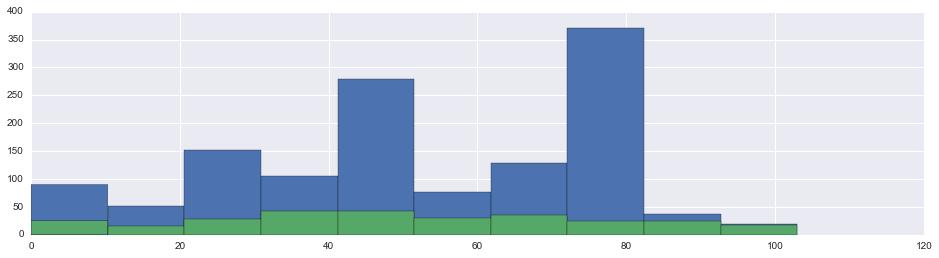

In [86]:
fig, ax = plt.subplots(figsize=(16,4))

union.ImputedCabinNumberEncoding.hist(ax=ax)
union.CabinNumberEncoding.hist(ax=ax)

### Cabin N-Tile

Take a look at the min and max of our cabins

In [87]:
union.loc[~union.CabinNumber.isnull(), 'CabinNumber'] = union[~union.CabinNumber.isnull()].CabinNumber.astype(int)

In [88]:
union.CabinNumber.min(), union.CabinNumber.max()

(2, 148)

In [89]:
def cabin_tile(x):
    if x == np.NAN:
        return np.NAN

    if x <= 50:
        return 0
    elif x <= 100:
        return 1
    else:
        return 2

union['CabinTertile'] = union.CabinNumber
union.loc[~union.CabinTertile.isnull(), 'CabinTertile'] = union.CabinTertile[~union.CabinTertile.isnull()].apply(cabin_tile)
union['ImputedCabinTertile'] = union.CabinTertile

In [90]:
params_cabinnumber = {'n_estimators': [10, 20, 50, 100]}
clf_cabinnumber = sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), params_cabinnumber)

clf_cabinnumber = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

clf_cabinnumber.fit(union[~union.CabinTertile.isnull()][features_cabinnumber], union[~union.CabinTertile.isnull()].CabinTertile.astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [91]:
union.loc[union.CabinTertile.isnull(), 'ImputedCabinTertile'] = clf_cabinnumber.predict(union[union.CabinTertile.isnull()][features_cabinnumber])

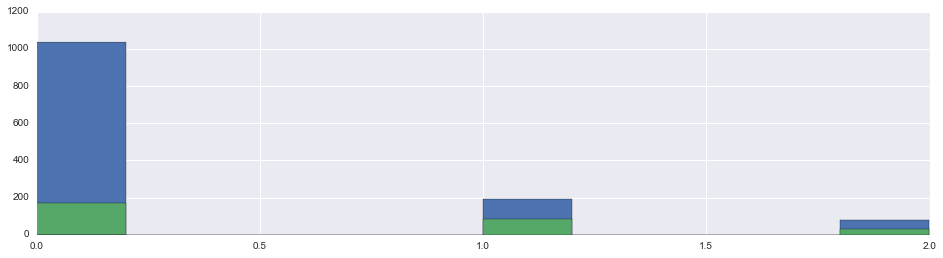

In [92]:
fig, ax = plt.subplots(figsize=(16,4))

union.ImputedCabinTertile.hist(ax=ax)
union.CabinTertile.hist(ax=ax)

## Model Fitting

### Base Line

If we just predicted everyone to not surive, then we'd have 61.6% accuracy rate. So this is the minimum base life we have to beat with our classifier.

In [93]:
len(union[union.Survived == 0]) / len(union[~union.Survived.isnull()])

0.6161616161616161

### Null Checks

In [94]:
features = ['EmbarkedEncoding', 'Parch', 'PclassEncoding', 'SexEncoding', 'SibSp', 'TitleEncoding', 'FamilySize', 'Alone',
             'FamilyNameEncoding', 'ImputedAge', 'Mother', 'ImputedFare', 'TicketGroupEncoding', 'ImputedCabinTertile']

Check for null entries in our features

In [95]:
# Make sure that there are no Nan entries in our dataset
union[features][~union.Survived.isnull()][pd.isnull(union[features][~union.Survived.isnull()]).any(axis=1)]

,EmbarkedEncoding,Parch,PclassEncoding,SexEncoding,SibSp,TitleEncoding,FamilySize,Alone,FamilyNameEncoding,ImputedAge,Mother,ImputedFare,TicketGroupEncoding,ImputedCabinTertile


Okay, good, the above gave us no rows of null entries. We can continue.

### Fitting

I've commented out a few classifiers I've tried to fit the model with. If you've cloned this note book, you can easily uncomment out thos rows and check out the results for yourselves.

For each classifier, I've decided to use grid search cross validation, and have the grid search return the best parameter with the best cross validation score.

In [96]:
params_c = {'C':[0.005, 0.1,0.5,1,2,5]}
params_n_estimators = {'n_estimators':[100, 500,1000,2000,4000]}

clfs = []
training_filter = ~union.Survived.isnull()

#clfs.append(sklearn.grid_search.GridSearchCV(sklearn.linear_model.LogisticRegression(), params_c, cv=5, scoring='f1'))
#clfs.append(sklearn.grid_search.GridSearchCV(sklearn.svm.SVC(), params_c, cv=5, n_jobs=4))
clfs.append(sklearn.grid_search.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), params_n_estimators, cv=5, n_jobs=4))
#clfs.append(sklearn.grid_search.GridSearchCV(sklearn.ensemble.AdaBoostClassifier(), params_n_estimators, cv=5, n_jobs=4))
#clfs.append(sklearn.naive_bayes.GaussianNB())

for clf in clfs:
    clf.fit(union[training_filter][features], union[training_filter].Survived)

print('models fitted')

models fitted


In [97]:
for clf in clfs: 
    if isinstance(clf, sklearn.grid_search.GridSearchCV):
        print(clf.best_estimator_)
        print(clf.best_params_)
        print(clf.best_score_)
        print(clf.grid_scores_)
        print('\n')
    #elif isinstance(clf, sklearn.naive_bayes.GaussianNB):
    else:
        print(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 1000}
0.836139169473
[mean: 0.83165, std: 0.01960, params: {'n_estimators': 100}, mean: 0.83502, std: 0.02227, params: {'n_estimators': 500}, mean: 0.83614, std: 0.02388, params: {'n_estimators': 1000}, mean: 0.83165, std: 0.02245, params: {'n_estimators': 2000}, mean: 0.83614, std: 0.02537, params: {'n_estimators': 4000}]




How well have we trained against our own training set. 

In [98]:
for clf in clfs:
    y_train_pred = clf.predict(union[training_filter][features])
    print(type(clf.best_estimator_) if isinstance(clf, sklearn.grid_search.GridSearchCV) else type(clf))
    print(sklearn.metrics.classification_report(y_train_pred, union[training_filter].Survived))


<class 'sklearn.ensemble.forest.RandomForestClassifier'>
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       548
        1.0       1.00      1.00      1.00       343

avg / total       1.00      1.00      1.00       891



How important were each of the features in our random forest?

In [99]:
for clf in clfs:
    if isinstance(clf, sklearn.grid_search.GridSearchCV):
        if isinstance(clf.best_estimator_, sklearn.ensemble.forest.RandomForestClassifier):
            print('Random Forest:')
            print(pd.DataFrame(list(zip(clf.best_estimator_.feature_importances_, features))
                               , columns=['Importance', 'Feature']).sort_values('Importance', ascending=False))

Random Forest:
    Importance              Feature
3     0.172208          SexEncoding
11    0.162787          ImputedFare
8     0.156656   FamilyNameEncoding
9     0.144165           ImputedAge
5     0.109166        TitleEncoding
2     0.068891       PclassEncoding
6     0.041045           FamilySize
12    0.034973  TicketGroupEncoding
4     0.026276                SibSp
0     0.024488     EmbarkedEncoding
13    0.024164  ImputedCabinTertile
1     0.016559                Parch
7     0.010641                Alone
10    0.007981               Mother


How certain we are of our predictions? We can graph it out using predict proba.

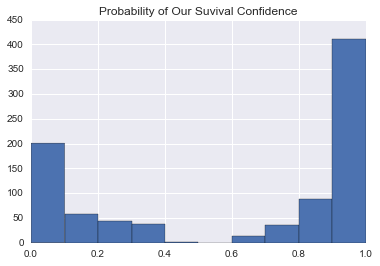

In [100]:
for clf in clfs:
    if callable(getattr(clf, 'predict_proba', None)):
        pd.Series(clf.predict_proba(union[training_filter][features])[:,0]).hist()
        plt.title('Probability of Our Suvival Confidence')

# Submission

Finally, we'll loop through all our classifiers and save the predicted csv file.

In [101]:
final_submission = []
for i, clf in enumerate(clfs):
    final_submission.append(union[~training_filter].copy())
    final_submission[i]['Survived'] = pd.DataFrame(clf.predict(union[~training_filter][features]))
    name = clf.best_estimator_.__class__.__name__ if isinstance(clf, sklearn.grid_search.GridSearchCV) else clf.__class__.__name__
    
    final_submission[i].Survived = final_submission[i].Survived.astype(int)
    final_submission[i].to_csv('titanic_{}.csv'.format(name), columns=['PassengerId', 'Survived'], index=False)

## Extras

Over here, we have the learning curve analysis from Andrew Ng's machine learning class.

In [102]:
from sklearn import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#for clf in clfs:
#    name = clf.best_estimator_.__class__.__name__ if isinstance(clf, sklearn.grid_search.GridSearchCV) else clf.__class__.__name__
#    plot_learning_curve(clf, name, union[training_filter][features], union[training_filter].Survived, train_sizes=np.linspace(0.3,1,5))

# Conclusion

Was definitely fun developing this notebook, and hopefully it has helped anyone who's trying to tackle the Kaggle Titanic problem. And again, if you're looking for the source of the Jupyter notebook, it can be found in the introduction. Thanks for reading!